# Running the ADHunter Notebook with Explicit 1HE

In [8]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNOneHotSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger

pl.seed_everything(0)
os.chdir("../adhunter")

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "data/OrthologTilingDFwActivities_20220131.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()



df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]


seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)


# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

train, val, test = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test

In [10]:
import torch.nn.functional as Fun
# def encode(val: str, ref: dict):
#     """
#     Encodes a nucleotide or codon value as a one-hot vector 
#     based on the provided reference dictionary.

#     Args:
#         val (str): The value to be encoded (e.g., nucleotide or codon).
#         ref (dict): A dictionary mapping values to indices.

#     Returns:
#         np.ndarray: A one-hot encoded vector of the input value.
#         Note that if the input value is not in the provided dictionary, 
#         will return a 0 vector.
#     """    
#     output = np.zeros(len(ref))
#     if val in ref:
#         output[ref[val]] = 1
#     return output
def one_hot(idx, n_classes):
    arr = np.zeros(n_classes)
    if idx in range(n_classes):
        arr[idx] = 1
    return arr
# def one_hot(input, num_classes=None):
#     # If num_classes is not specified, set it to the max value in input + 1
#     if num_classes is None:
#         num_classes = input.max().item() + 1

#     # Create a tensor of zeros with shape (input.size(0), num_classes)
#     shape = input.size() + (num_classes,)
#     out = torch.zeros(shape, dtype=torch.float, device=input.device)

#     # Set indices that are less than num_classes to 1, and others will stay 0
#     mask = input < num_classes
#     out.scatter_(-1, input.unsqueeze(-1), 1)

#     # Ensure that out is 0 wherever the condition is not satisfied
#     out[~mask] = 0

#     return out
# one_hot(X[0, 0], 20)
# np.zeros(20)[1]
# np.zeros(20)
# X[0]
# Fun.one_hot(torch.tensor(X))
# one_hot(torch.tensor(X)).shape

def one_hot(input, num_classes=None):
    # Check if num_classes is provided, otherwise set it from the maximum value of the input
    if num_classes is None:
        num_classes = input.max().item() + 1

    # Create a tensor of zeros with shape (input.size(0), num_classes)
    shape = input.size() + (num_classes,)
    out = torch.zeros(shape, dtype=torch.float, device=input.device)
    if (input >= num_classes).all():
        return out
    # Scatter the values of 1 at the appropriate indices
    out.scatter_(-1, input.unsqueeze(-1), 1)

    return out


x = torch.tensor(X)
one_hot(x)
one_hot(torch.zeros(40, dtype=torch.int64) + 20, num_classes=20).shape

# for i in range(x.shape[0]):
#     for j in range(x.shape[1]):
#         x[i, j] = torch.zeros(20, dtype=torch.int64)

torch.Size([40, 20])

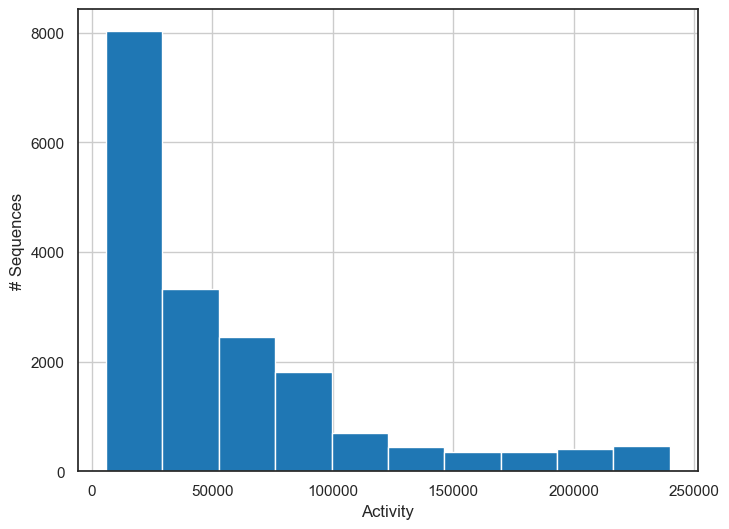

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
df.Activity.hist(ax=ax)
ax.set(xlabel="Activity")
ax.set(ylabel="# Sequences")
sns.set_context('poster')

In [12]:
# Create Training and Validation Datasets
pl.seed_everything(0)

bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

Global seed set to 0


## Train the Model

In [13]:
# import pytorch_lightning as pl
# import torch
# import torch.nn as nn
# import torch.nn.functional as Fun
# from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
# from sklearn.preprocessing import OneHotEncoder

# from actpred.models import ResBlock

# # def one_hot(input, num_classes=None):
# #     # Check if num_classes is provided, otherwise set it from the maximum value of the input
# #     if num_classes is None:
# #         num_classes = input.max().item() + 1

# #     # Create a tensor of zeros with shape (input.size(0), num_classes)
# #     shape = input.size() + (num_classes,)
# #     out = torch.zeros(shape, dtype=torch.float, device=input.device)
# #     if (input >= num_classes).all():
# #         return out
# #     # Scatter the values of 1 at the appropriate indices
# #     out.scatter_(-1, input.unsqueeze(-1), 1)

# #     return out

# def one_hot(input, num_classes=None):
#     # Check if num_classes is provided, otherwise set it from the maximum value of the input
#     if num_classes is None:
#         num_classes = input.max().item() + 1

#     # Create a tensor of zeros with shape (input.size(0), num_classes)
#     shape = input.size() + (num_classes,)
#     out = torch.zeros(shape, dtype=torch.float, device=input.device)

#     # Only scatter if the input values are within bounds
#     valid_input_mask = (input < num_classes)
#     out.scatter_(-1, input.unsqueeze(-1), 1)

#     # Set values for invalid input indices to 0 (no need to do anything for valid indices)
#     out[~valid_input_mask.unsqueeze(-1)] = 0

#     return out


# class ActCNNOneHot(nn.Module):
#     """ADHunter model class. Similar to ActCNN, but with explicit 
#     one-hot encoding fed into a linear layer to facilitate 
#     interpretability.
#     """
#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40):
#         super(ActCNNOneHot, self).__init__()
#         self.encoder = OneHotEncoder(dtype=torch.float32, categories=[list(range(20))], handle_unknown='ignore')
#         self.emb = nn.Linear(20, hidden, bias=False)
#         # self.emb = nn.Embedding(20, embedding_dim=hidden, dtype=torch.float32)
#         self.conv_init = nn.Conv1d(in_channels=hidden,
#                                    kernel_size=kernel_size,
#                                    out_channels=hidden,
#                                    padding="same")
#         self.res_blocks = nn.ModuleList([
#             ResBlock(hidden, kernel_size, dilation)
#             for _ in range(num_res_blocks)
#         ])
#         self.pool = nn.MaxPool1d(kernel_size=seq_len)
#         self.lin = nn.Linear(hidden, 1)

#     def forward(self, X):
#         X = one_hot(X, num_classes=20).float()
#         out = self.emb(X)
#         out = out.transpose(2, 1)
#         out = self.conv_init(out)
#         for res_block in self.res_blocks:
#             out = res_block(out)
#         out = self.pool(out).squeeze()
#         out = self.lin(out)
#         return out


# class ActCNNOneHotSystem(pl.LightningModule):
#     """Wrapper for ActCNNOneHot model.
#     """
#     def __init__(self,
#                  hidden,
#                  kernel_size,
#                  dilation,
#                  num_res_blocks=3,
#                  seq_len=40,
#                  weight_decay=1e-2):
#         super(ActCNNOneHotSystem, self).__init__()
#         self.save_hyperparameters()
#         self.wd = weight_decay
#         self.model = ActCNNOneHot(hidden,
#                             kernel_size,
#                             dilation,
#                             seq_len=seq_len,
#                             num_res_blocks=num_res_blocks)
#         self.loss_fn = nn.MSELoss()

#         self.rmse = MeanSquaredError(squared=False)
#         self.pearsonr = PearsonCorrCoef()
#         self.spearmanr = SpearmanCorrCoef()
#         self.metrics = {
#             "rmse": self.rmse,
#             "pearsonr": self.pearsonr,
#             "spearmanr": self.spearmanr
#         }

#     def forward(self, x):
#         return self.model(x)

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(),
#                                      lr=1e-3,
#                                      weight_decay=self.wd)
#         return optimizer

#     def training_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         loss = self.loss_fn(y_pred, y)
#         return {
#             "loss": loss,
#             "y_target": y.view(-1),
#             "y_pred": y_pred.detach().view(-1),
#         }

#     def training_epoch_end(self, train_step_outputs):
#         y_preds = [d['y_pred'] for d in train_step_outputs]
#         y_targets = [d['y_target'] for d in train_step_outputs]
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         train_loss = self.metrics['rmse'](y_preds, y_targets)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "train_" + metric_name
#             self.log(metric_name, metric(y_preds, y_targets))
#         return

#     def validation_step(self, batch, batch_idx):
#         X, y = batch
#         y_pred = self.model(X)
#         return (y_pred.view(-1), y.view(-1))

#     def validation_epoch_end(self, val_step_outputs):
#         y_preds, y_targets = zip(*val_step_outputs)
#         y_preds = torch.concat(y_preds)
#         y_targets = torch.concat(y_targets)

#         val_loss = self.metrics['rmse'](y_preds, y_targets)
#         self.log("val_loss", val_loss)
#         for metric_name, metric in self.metrics.items():
#             metric_name = "val_" + metric_name
#             print(metric_name, metric(y_preds, y_targets).item(), flush=True)
#             self.log(metric_name, metric(y_preds, y_targets))
#         return val_loss

In [14]:
# encoder = OneHotEncoder(handle_unknown="ignore", categories=[range(20)], sparse_output=False)
# print(X_train.shape)
# encoder.fit_transform(X_train.reshape(-1, 1)).reshape(14653, 40, 20).shape
# # torch.tensor(encoder.fit_transform(X_train).toarray(), device=X_train.device)
# one_hot(baseline_null, num_classes=20)

In [15]:
# Train Model
kernel_size = 5
dilation = 3 
hidden = 64


model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
dirpath="models"
csv_logger = CSVLogger('logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNNOneHot     | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearma

Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 31.06it/s]val_rmse 1.108262062072754
val_pearsonr 0.08557015657424927
val_spearmanr 0.11010280251502991
                                                                           

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 130/130 [00:01<00:00, 66.91it/s, loss=0.513, v_num=32]val_rmse 0.7239258885383606
val_pearsonr 0.7082771062850952
val_spearmanr 0.6427605152130127
Epoch 1: 100%|██████████| 130/130 [00:01<00:00, 69.75it/s, loss=0.43, v_num=32] val_rmse 0.6866971254348755
val_pearsonr 0.7384626865386963
val_spearmanr 0.6506236791610718
Epoch 2: 100%|██████████| 130/130 [00:02<00:00, 54.27it/s, loss=0.429, v_num=32]val_rmse 0.6867619752883911
val_pearsonr 0.746609091758728
val_spearmanr 0.6745498180389404
Epoch 3: 100%|██████████| 130/130 [00:01<00:00, 74.24it/s, loss=0.378, v_num=32]val_rmse 0.6769113540649414
val_pearsonr 0.7471845149993896
val_spearmanr 0.6858740448951721
Epoch 4: 100%|██████████| 130/130 [00:01<00:00, 81.63it/s, loss=0.379, v_num=32]val_rmse 0.6655571460723877
val_pearsonr 0.7641998529434204
val_spearmanr 0.6956622004508972
Epoch 5: 100%|██████████| 130/130 [00:01<00:00, 83.75it/s, loss=0.366, v_num=32]val_rmse 0.6811713576316833
val_pearsonr 0.7604072093963

In [16]:
# get best model and save it
model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
torch.save(model.cpu().state_dict(), "adhunter_1he.pt")

In [17]:
# Load model 
model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))

<All keys matched successfully>

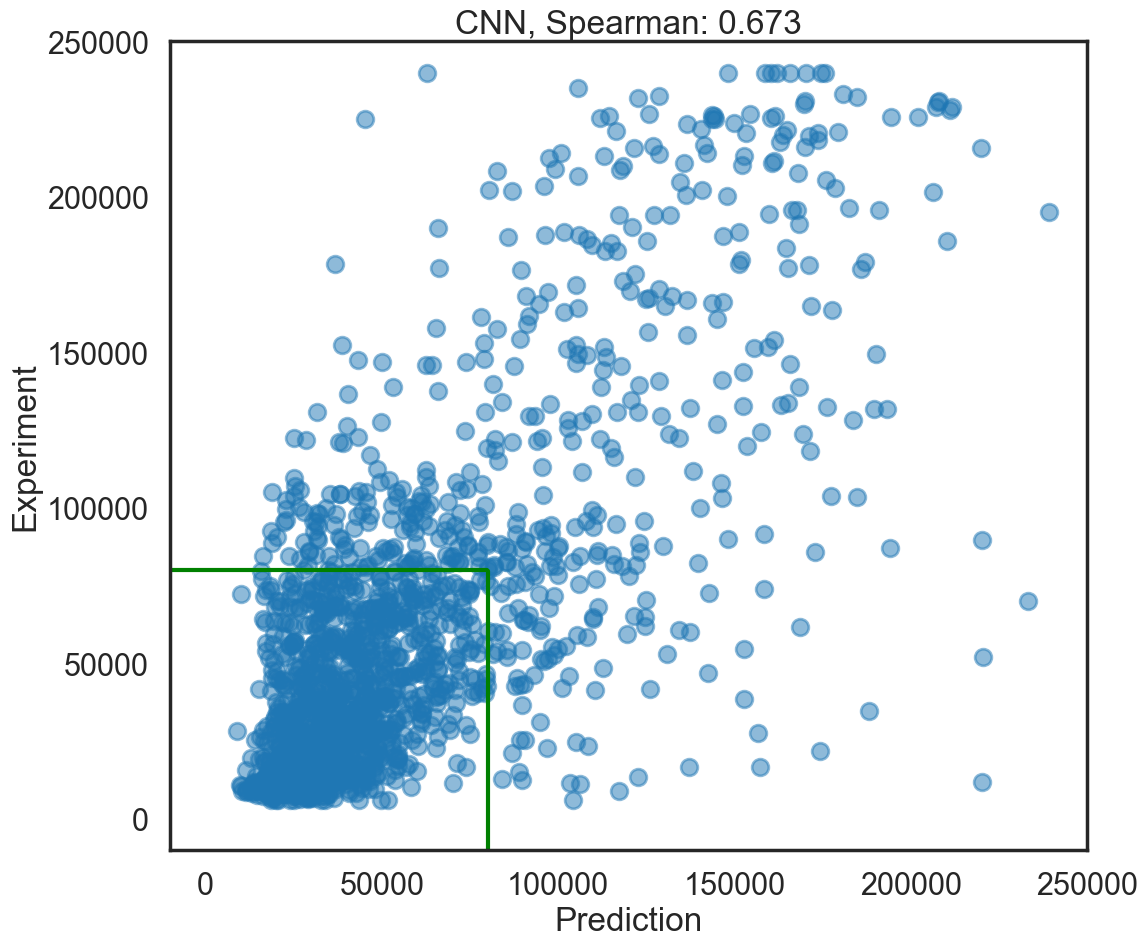

In [18]:
test_ds = TensorDataset(X_test, y_cont_test.to(torch.float))
test_dl = DataLoader(test_ds, batch_size=bs)

model.eval()
X_test, y_test = test_ds[:]
y_test = y_test.reshape(-1)
with torch.no_grad():
    y_test_hat = model(X_test).reshape(-1)
    y_test_hat = y_test_hat.detach().numpy()
    y_test = y_test.numpy()

best_thresh = get_threshold(y_bin_test, y_test_hat)
best_thresh_unscaled = scaler.inverse_transform(np.asarray([best_thresh]).reshape(-1, 1)).item()
y_test_hat_bin = (y_test_hat > best_thresh).astype(np.int32)

y_test_hat_unscaled = scaler.inverse_transform(y_test_hat.reshape(-1, 1)).reshape(-1)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(y_test_hat_unscaled, y_test_unscaled, alpha=0.5)
corr = spearmanr(y_test_hat_unscaled, y_test_unscaled).correlation
ax.set(xlabel="Prediction", ylabel="Experiment", title=f"CNN, Spearman: {corr:.3f}")
ax.set(xlim=(-10000, 250_000), ylim=(-10000, 250_000))
plt.tight_layout()
plt.axvline(x=80_000, c='green', ymax=0.345)
plt.axhline(y=80_000, c='green', xmax=0.345)
plt.show()

# Captum DeepLIFT

In [19]:
# weak = "PTPEAFAADTITRFQTTANTQVSSPCSFRSIERNQFRRSS"
# strong = "IEESMDECIRWLENPFLNQFIAGFDLIGEEATEKHPLIYH"
weak = "EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ"
strong = "ASYNPVVSNNASASEVRGVPAPEDDFDDAMNLWMGLHGPK"
def encode(seq):
    assert len(seq) == 40, "Sequence must be 40 AA!"
    return torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64)


strongAD, weakAD = encode(strong), encode(weak)
# model(encode(weak))
# print(encode(weak))
# print(model(), model())
# sample_input

In [20]:
from captum.attr import LayerDeepLift
sns.reset_defaults()

sample_input = torch.randint(0, 20, (1, 40), dtype=torch.int64)
baseline_null = torch.zeros(1, 40, dtype=torch.int64) + 21
baseline_gs = encode("".join(["GS" for _ in range(20)]))

# baseline = weakAD
# baseline = torch.zeros_like(sample_input, dtype=torch.int64)
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=False,)

def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True)
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap="bwr", center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
(baseline_null >= 20).all()

tensor(True)

In [23]:
# get_attr(dl, sample_input, baseline=baseline_null)
print(model(strongAD))
# model(baseline_null)

tensor([2.1261], grad_fn=<ViewBackward0>)


In [24]:
# plot_attr(attr_df, title="Random Peptide")
# plt.show()
print(baseline_null)
one_hot(baseline_null, num_classes=20)

tensor([[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21]])


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],

In [25]:
# 1: ATTRIBUTE WITH GS BASELINE
# Get attributions for a random peptide
attr_gs_baseline_df = get_attr(dl, sample_input, baseline=baseline_gs)
# Get attributions for train and test sets
attr_train_gs_baseline_df = get_attr(dl, X_train, baseline=baseline_gs)
attr_test_gs_baseline_df = get_attr(dl, X_test, baseline=baseline_gs)
# Get attributions for full dataset
X_full = torch.tensor(X)
attr_full_gs_baseline_df = get_attr(dl, X_full, baseline=baseline_gs)
attr_strong_gs_baseline_df = get_attr(dl, strongAD, baseline=baseline_gs)
attr_weak_gs_baseline_df = get_attr(dl, weakAD, baseline=baseline_gs)


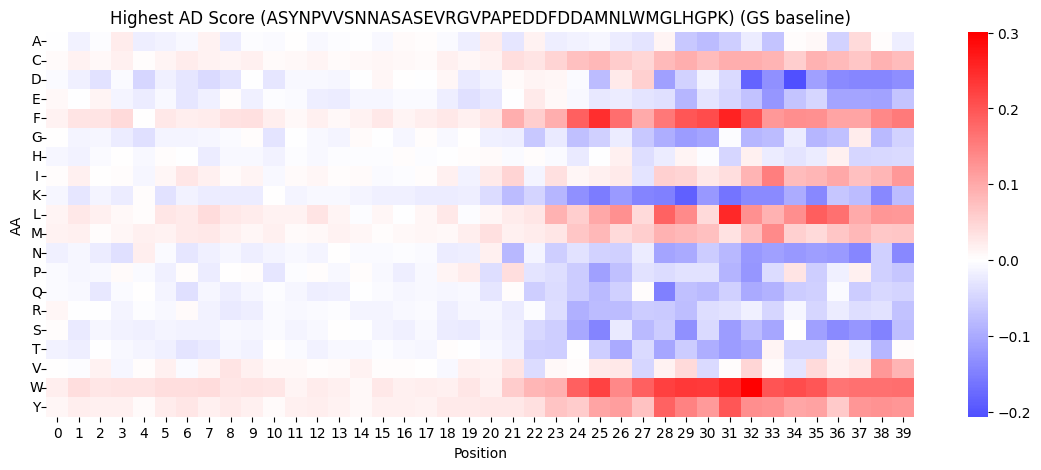

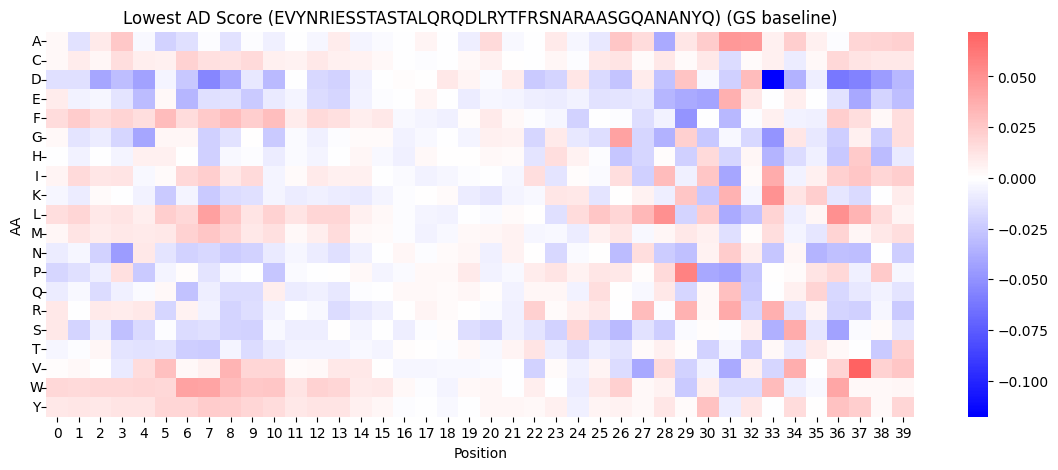

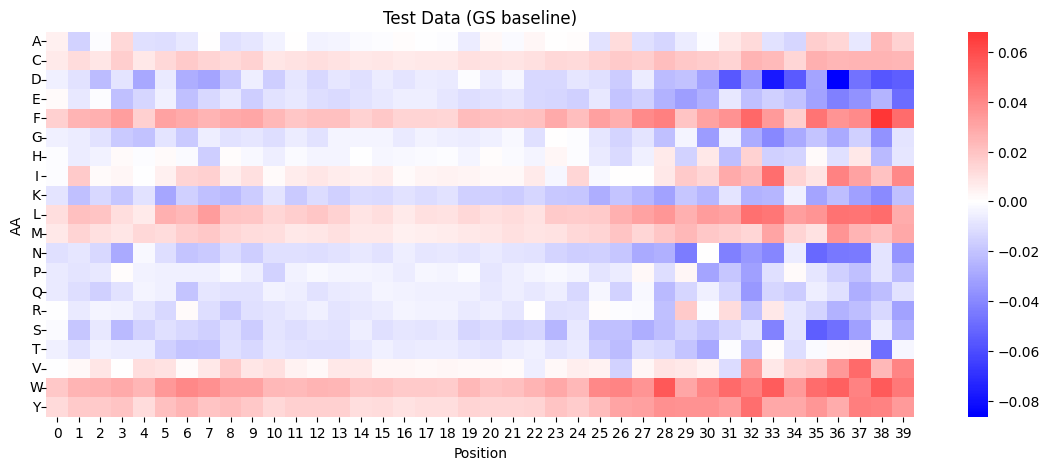

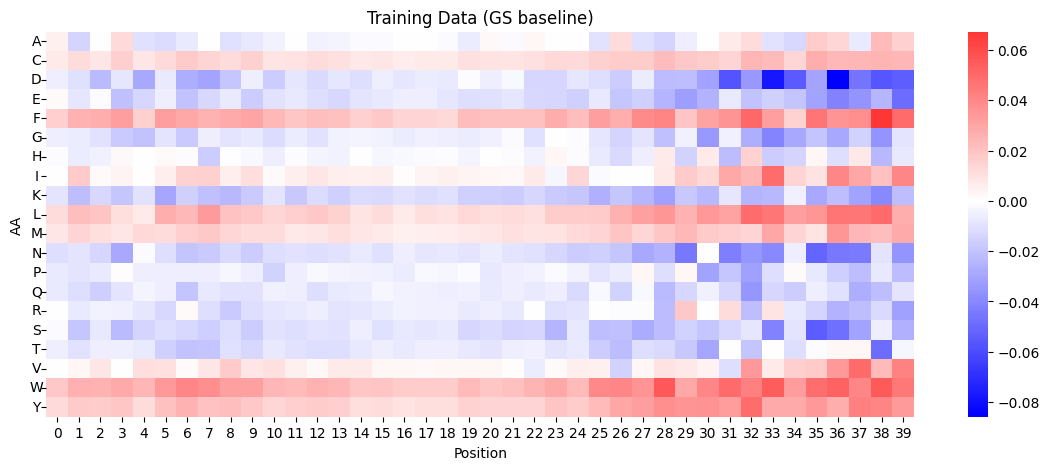

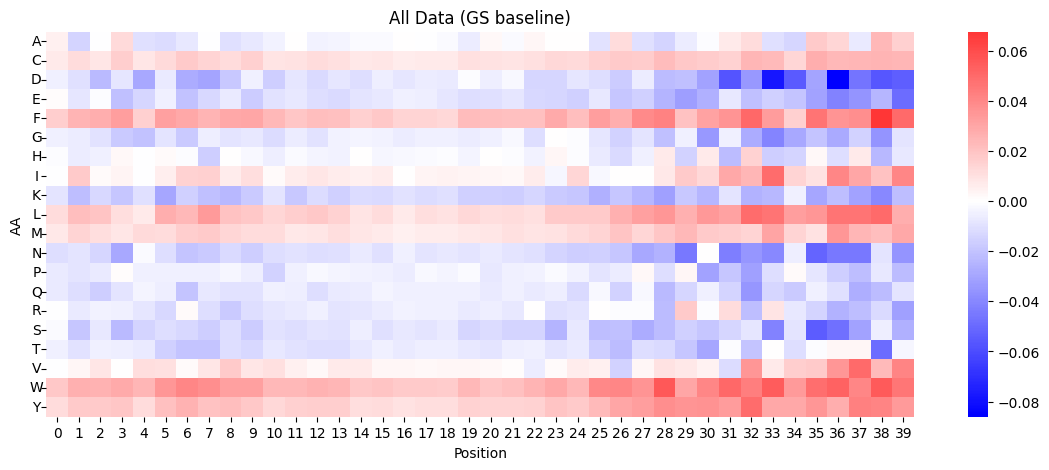

In [26]:
plot_attr(attr_strong_gs_baseline_df, title=f"Highest AD Score ({strong}) (GS baseline)")
plt.show()
plot_attr(attr_weak_gs_baseline_df, title=f"Lowest AD Score ({weak}) (GS baseline)")
plt.show()
plot_attr(attr_test_gs_baseline_df, title="Test Data (GS baseline)")
plt.show()
plot_attr(attr_train_gs_baseline_df, title="Training Data (GS baseline)")
plt.show()
plot_attr(attr_full_gs_baseline_df, title="All Data (GS baseline)")
plt.show()

In [27]:
# 2: ATTRIBUTE WITH WEAK AD AS BASELINE
# Get attributions for a random peptide
attr_weakbaseline_df = get_attr(dl, sample_input, baseline=weakAD)
# Get attributions for train and test sets
attr_train_weakbaseline_df = get_attr(dl, X_train, baseline=weakAD)
attr_test_weakbaseline_df = get_attr(dl, X_test, baseline=weakAD)
# Get attributions for full dataset
X_full = torch.tensor(X)
attr_full_weakbaseline_df = get_attr(dl, X_full, baseline=weakAD)
attr_strong_weakbaseline_df = get_attr(dl, strongAD, baseline=weakAD)
attr_weak_weakbaseline_df = get_attr(dl, weakAD, baseline=weakAD)

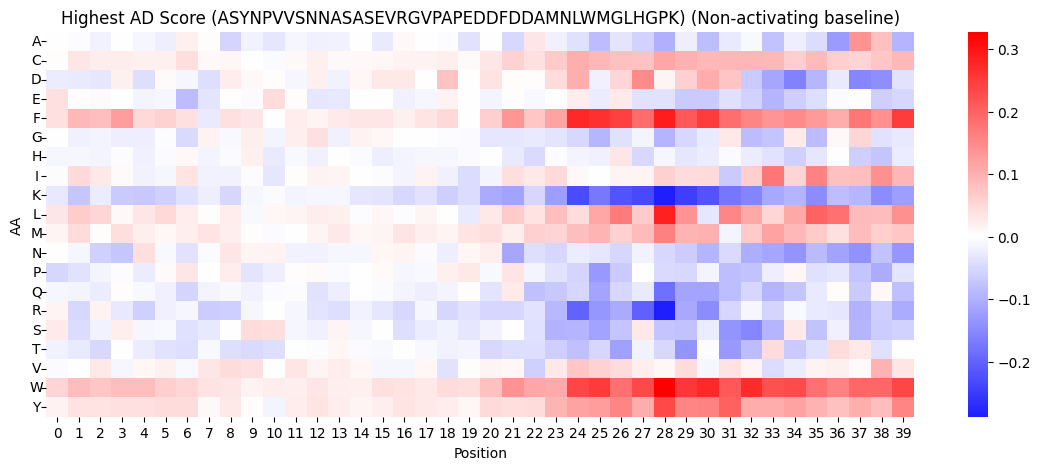

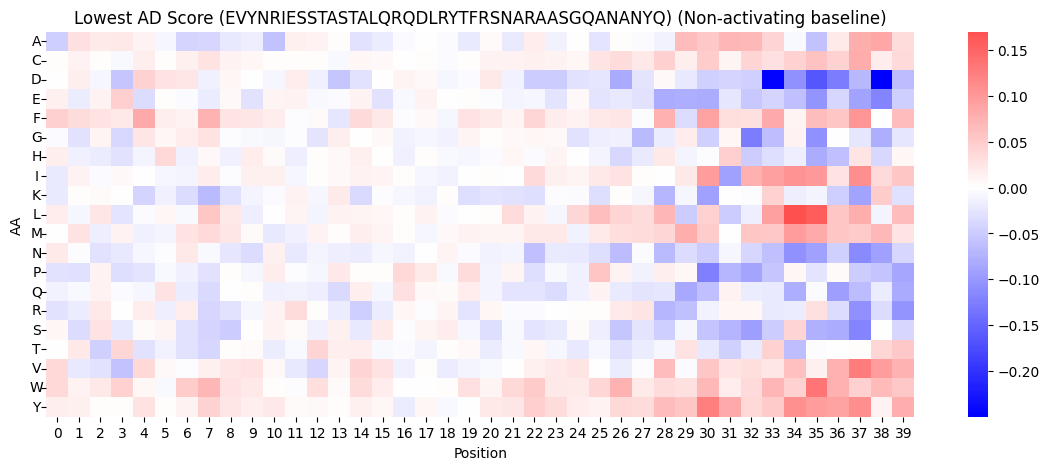

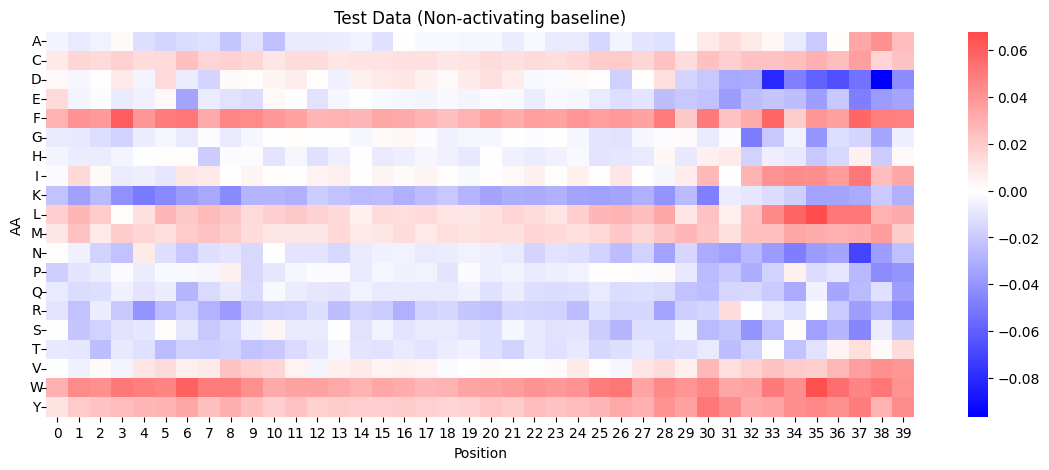

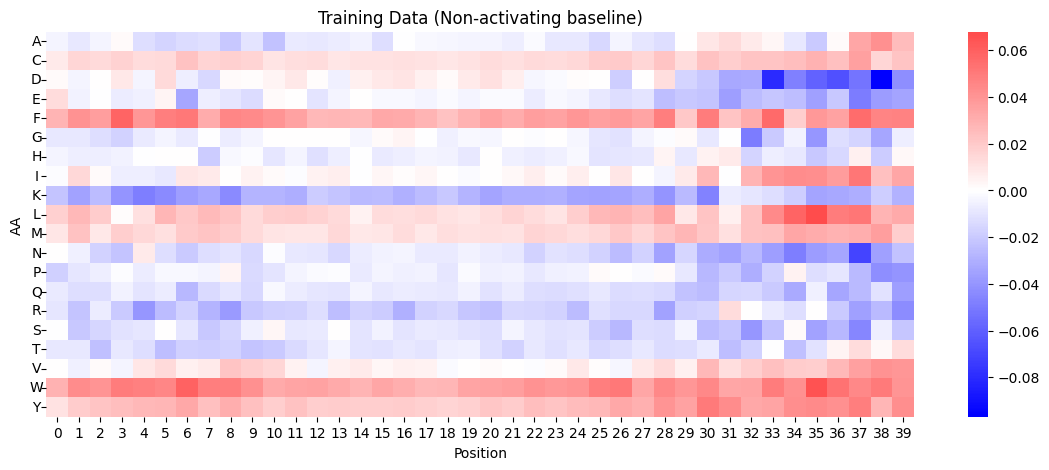

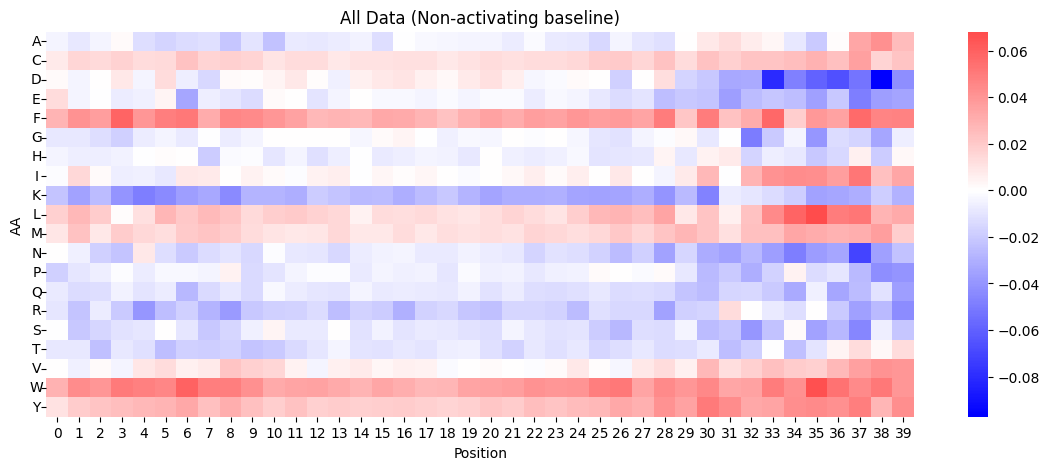

In [28]:
plot_attr(attr_strong_weakbaseline_df, title=f"Highest AD Score ({strong}) (Non-activating baseline)")
plt.show()
plot_attr(attr_weak_weakbaseline_df, title=f"Lowest AD Score ({weak}) (Non-activating baseline)")
plt.show()
plot_attr(attr_test_weakbaseline_df, title="Test Data (Non-activating baseline)")
plt.show()
plot_attr(attr_train_weakbaseline_df, title="Training Data (Non-activating baseline)")
plt.show()
plot_attr(attr_full_weakbaseline_df, title="All Data (Non-activating baseline)")
plt.show()

In [29]:
resn_props = {
    "acidic": ["D", "E"],
    "hydrophobic": ["A", "V", "I", "L", "M", "F", "Y", "W"],
    "aromatic": ["F", "Y", "W"]
}


## TODO
- Importance | Activator
- Importance | Acidic resn present
- Importance | Hydrophobic resn present
- Importance | Aromatic resn present

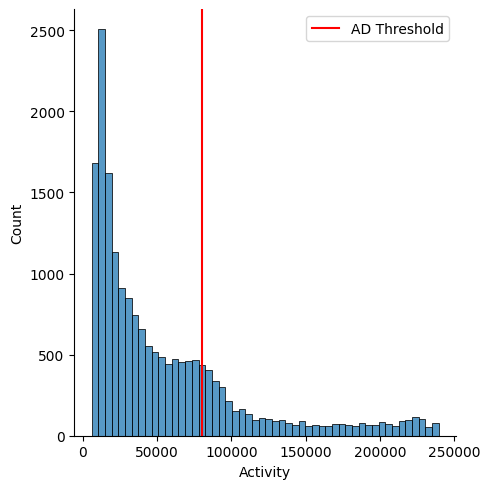

In [30]:
sns.displot(df["Activity"])#, kind="kde")
ad_threshold = 80_000
plt.axvline(ad_threshold, c='r', label="AD Threshold")
plt.legend()
plt.show()

In [31]:
X_ad = torch.tensor(X[np.where(df["Activity"] >= ad_threshold)[0]])

att_ad_df_weakad = get_attr(dl, X_ad, baseline=weakAD)
att_ad_df_gs = get_attr(dl, X_ad, baseline=baseline_gs)
# dl_mbi = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
# attr_ = dl_mbi.attribute(X_ad, baselines=weakAD, attribute_to_layer_input=True)
# attr_ad_df = pd.DataFrame(attr_.detach().numpy().mean(axis=0)).T
# attr_ad_df.index = list(alphabet)
# # attr_ad_df = get_attr(dl, X_ad, baseline)

In [32]:
weak[6]

'E'

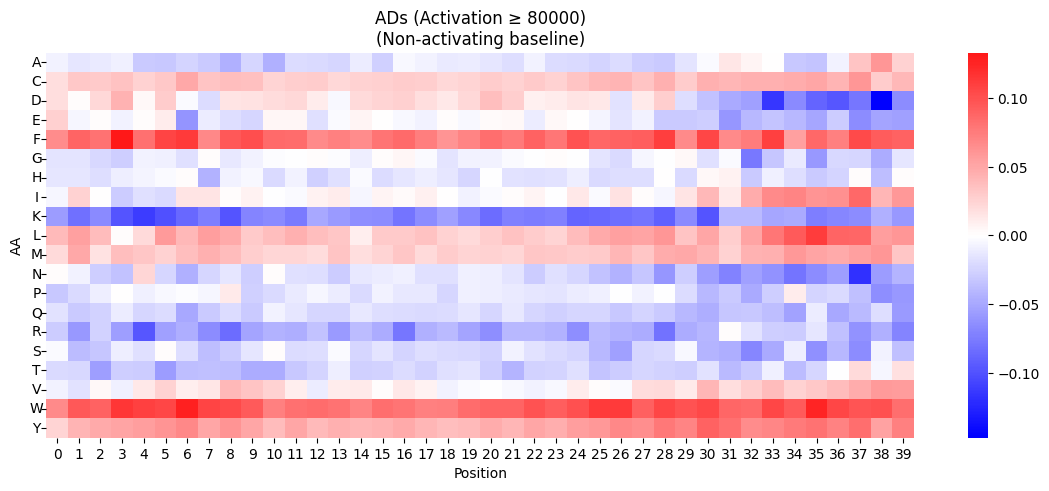

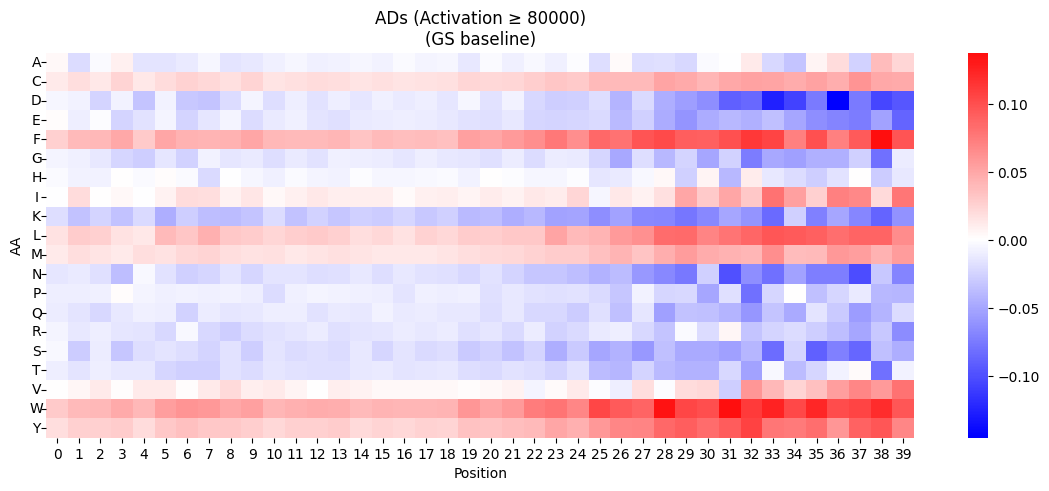

In [33]:
plot_attr(att_ad_df_weakad, title=f"ADs (Activation \u2265 {ad_threshold})\n(Non-activating baseline)")
plt.show()
plot_attr(att_ad_df_gs, title=f"ADs (Activation \u2265 {ad_threshold})\n(GS baseline)")
plt.show()

In [34]:
# sns.clustermap(attr_ad_df, 
#                col_cluster=False, cmap="bwr", center=0,
#                dendrogram_ratio=.1,
#                )
# # print(plt.yticklabels())
# plt.suptitle(f"ADs (Activation \u2265 {ad_threshold})")
# plt.show()

In [ ]:
# from torchviz import make_dot

# dot = make_dot(model(sample_input), params=dict(model.named_parameters()))
# dot.format = 'png'
# dot.render('simple_net')
# dot